# RNNs

## Импорт и подготовка данных

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Flatten, GRU
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
%cd drive/MyDrive/Colab\ Notebooks/NN

/content/drive/MyDrive/Colab Notebooks/NN


In [3]:
df = pd.read_csv('./airline-passengers.csv')

In [4]:
df.head(2)

,Month,Passengers
0,1949-01,112
1,1949-02,118


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
# преобразование категориального признака месяца в числовые признаки

df['year'], df['month'] = [int(row[0]) for row in df.Month.apply(lambda x: x.split('-'))], [int(row[1]) for row in df.Month.apply(lambda x: x.split('-'))]

In [7]:
# Отбрасываем категориальный признак
df = df.iloc[:, 1:]
df.head(1)

,Passengers,year,month
0,112,1949,1


In [8]:
# Количество данных в обучающей выборке
train_size = int(df.shape[0] * 0.7)

# Смещение тестовой выборки от обучающей
bias = 5

# разбиение данных на трейн и тест
train = df.iloc[:train_size]
test = df.iloc[train_size + bias:]
print('Размерность обучающей выборки: ', train.shape)
print('Размерность тестовой выборки: ', test.shape)

Размерность обучающей выборки:  (100, 3)
Размерность тестовой выборки:  (39, 3)


In [9]:
feats = train.columns[1:]
target = train.columns[0]

In [10]:
# Стандартизация
scaler = StandardScaler()

train[feats] = scaler.fit_transform(train[feats])
test[feats] = scaler.transform(test[feats])

In [11]:
# Длина истории
x_len = 4

# Горизонт предсказания
future = 1

# Параметры модели обучения
learning_rate = 0.001
batch_size = 10

In [12]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train[feats].values
y_train = df.iloc[start:end][target].values

x_end = len(test) - x_len - future
label_start = len(train) + bias + x_len + future
print(x_end, label_start)

X_test = test.iloc[:x_end][feats].values
y_test = df.iloc[label_start:][target].values

5 105
34 110


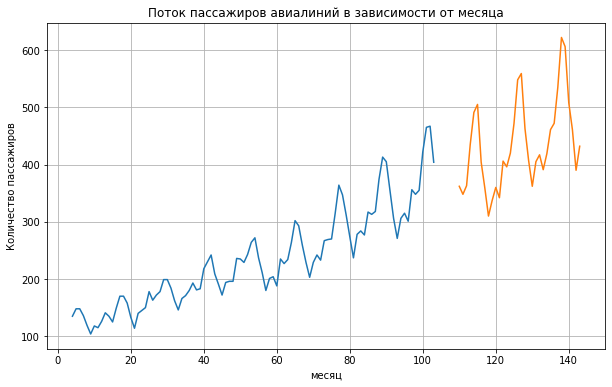

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(df.index[y_train.shape[0]+x_len+bias+future:],y_test[:])
plt.grid()
plt.xlabel('месяц')
plt.ylabel('Количество пассажиров')
plt.title('Поток пассажиров авиалиний в зависимости от месяца')
plt.show()

In [14]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size
)

dataset_test = tf.keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size
)

In [15]:
for batch in dataset_test:
    inputs, targets = batch
    print('Input shape: ', inputs.shape)
    print(inputs[0])
    print('Target shape: ', targets.shape)
    print(targets[0])
    break

Input shape:  (10, 4, 2)
tf.Tensor(
[[ 1.79106694  1.05198477]
 [ 1.79106694  1.3394123 ]
 [ 1.79106694  1.62683983]
 [ 2.20566577 -1.53486302]], shape=(4, 2), dtype=float64)
Target shape:  (10,)
tf.Tensor(362, shape=(), dtype=int64)


## SimpleRNN

In [16]:
%%time

tf.random.set_seed(52)

input = Input(shape=(inputs.shape[1:]))
output = SimpleRNN(64, return_sequences=True, dropout=0.0)(input)
output = Dense(64, activation='linear')(output)
output = Flatten()(output)
output = Dense(16, activation='linear')(output)
output = Dense(1, activation='relu')(output)


model_rnn = Model(input, output)
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='mse',
                metrics='mae')

# model_rnn.summary()

history_rnn = model_rnn.fit(dataset_train,
                            epochs=300,
                            validation_data=dataset_test,
                            callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True, min_delta=0.001),
                            verbose=1)

Epoch 1/300
10/10 [==============================] - 2s 66ms/step - loss: 56882.0938 - mae: 226.3753 - val_loss: 192704.5156 - val_mae: 431.6237
Epoch 2/300
10/10 [==============================] - 0s 23ms/step - loss: 55836.8984 - mae: 224.6114 - val_loss: 185777.5469 - val_mae: 423.5411
Epoch 3/300
10/10 [==============================] - 0s 24ms/step - loss: 53912.2461 - mae: 221.3463 - val_loss: 174210.2344 - val_mae: 409.7222
Epoch 4/300
10/10 [==============================] - 0s 26ms/step - loss: 50127.4805 - mae: 214.5810 - val_loss: 154793.9062 - val_mae: 385.3498
Epoch 5/300
10/10 [==============================] - 0s 19ms/step - loss: 43263.7891 - mae: 201.0555 - val_loss: 124599.6016 - val_mae: 343.9418
Epoch 6/300
10/10 [==============================] - 0s 30ms/step - loss: 32866.8398 - mae: 176.5569 - val_loss: 84745.7578 - val_mae: 280.0037
Epoch 7/300
10/10 [==============================] - 0s 25ms/step - loss: 21194.5527 - mae: 138.3382 - val_loss: 43956.3789 - val_m

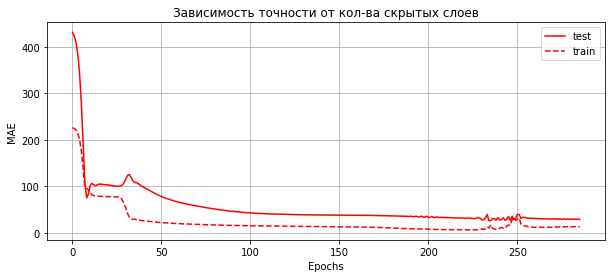

In [17]:
plt.figure(figsize=(10, 4))

plt.plot(history_rnn.history['val_mae'], 'r-', label='test')
plt.plot(history_rnn.history['mae'], 'r--', label='train')

plt.title(f'Зависимость точности от кол-ва скрытых слоев')
plt.legend()
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.show()

Улучшение качества модели получилось за счет добавления 2 скрытых слоев после RNN слоя, а также добавления слоя выравнивания (Flatten()) между скрытыми слоями.

In [40]:
pred_train_rnn = model_rnn.predict(dataset_train).flatten()
pred_test_rnn = model_rnn.predict(dataset_test).flatten()

4/4 [==============================] - 0s 5ms/step


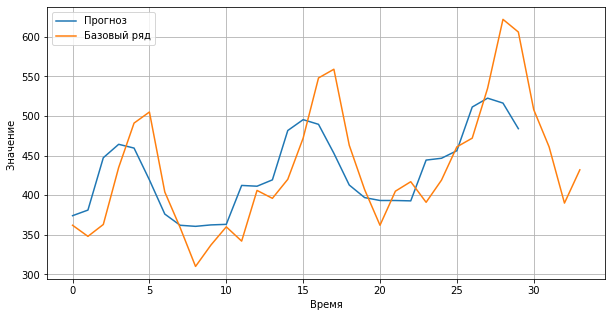

In [41]:
start = 0
step = 50

plt.figure(figsize=(10, 5))
plt.plot(pred_test_rnn[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_test.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.grid()
plt.legend()
plt.show()

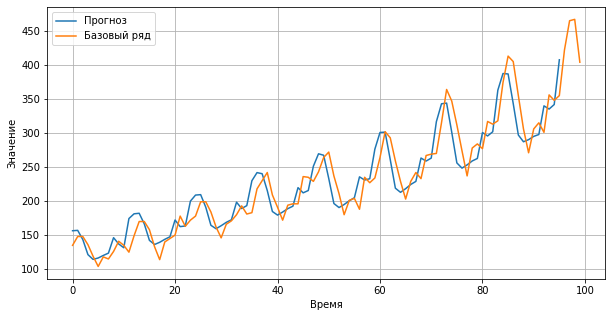

In [42]:
start = 0

plt.figure(figsize=(10, 5))
plt.plot(pred_train_rnn[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid()
plt.show()

In [21]:
print(model_rnn.evaluate(dataset_train))
print(model_rnn.evaluate(dataset_test))

10/10 [==============================] - 0s 6ms/step - loss: 137.2501 - mae: 9.7696
[137.2501220703125, 9.769610404968262]
4/4 [==============================] - 0s 10ms/step - loss: 1247.2180 - mae: 26.1521
[1247.218017578125, 26.152099609375]


## LSTM

In [22]:
%%time

tf.random.set_seed(52)

input = Input(shape=(inputs.shape[1:]))
output = LSTM(32, return_sequences=True, dropout=0.0)(input)
output = Dense(64, activation='linear')(output)
output = Flatten()(output)
output = Dense(32, activation='linear')(output)
output = Dense(1, activation='relu')(output)

model_lstm = Model(input, output)

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics='mae')

history_lstm = model_lstm.fit(dataset_train, 
                              batch_size=batch_size,
                              epochs=400,
                              validation_data=(dataset_test),
                              callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50,
                                                                         restore_best_weights=True, min_delta=0.001)
                              )

Epoch 1/400
10/10 [==============================] - 3s 71ms/step - loss: 57088.8906 - mae: 226.6695 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 2/400
10/10 [==============================] - 0s 15ms/step - loss: 56881.8984 - mae: 226.0215 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 3/400
10/10 [==============================] - 0s 15ms/step - loss: 56517.2695 - mae: 224.8978 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 4/400
10/10 [==============================] - 0s 14ms/step - loss: 55798.7852 - mae: 222.6735 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 5/400
10/10 [==============================] - 0s 13ms/step - loss: 54436.8242 - mae: 218.3403 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 6/400
10/10 [==============================] - 0s 17ms/step - loss: 52002.0352 - mae: 210.0811 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 7/400
10/10 [==============================] - 0s 16ms/step - loss: 48024.6562 - mae: 194.7754 - val_loss: 195559.0625 - val

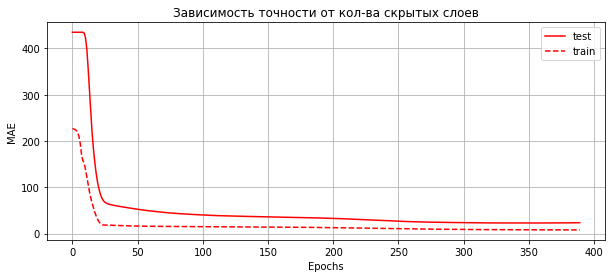

In [23]:
plt.figure(figsize=(10, 4))

plt.plot(history_lstm.history['val_mae'], 'r-', label='test')
plt.plot(history_lstm.history['mae'], 'r--', label='train')

plt.title(f'Зависимость точности от кол-ва скрытых слоев')
plt.legend()
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.show()

Модель на базе LSTM более плавно понижает ошибку на тестовой и обучающей выборках при обучении, а также с помощью этой модели удалось уменьшить ошибку на тестовой выборке путем увеличения количества нейронов в последнем скрытом слое модели, а также увеличением количества эпох обучения.

In [37]:
pred_train_lstm = model_lstm.predict(dataset_train).flatten()
pred_test_lstm = model_lstm.predict(dataset_test).flatten()

4/4 [==============================] - 0s 8ms/step


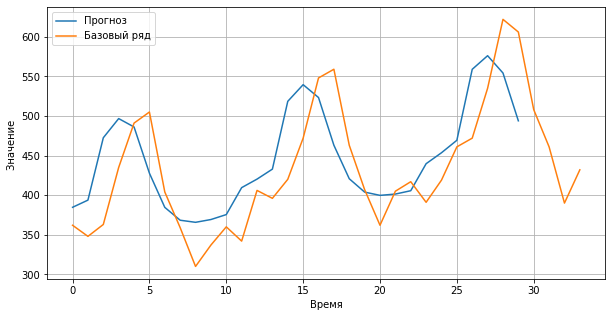

In [38]:
start = 0
step = 50

plt.figure(figsize=(10, 5))
plt.plot(pred_test_lstm[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_test.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.grid()
plt.legend()
plt.show()

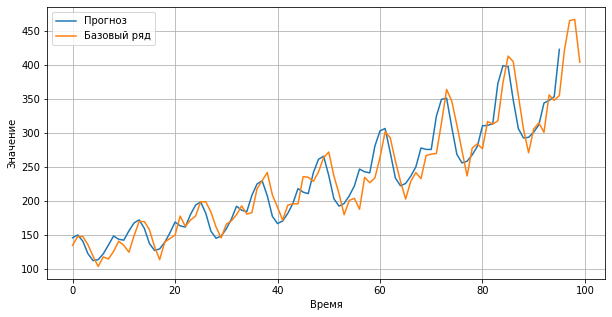

In [39]:
start = 0

plt.figure(figsize=(10, 5))
plt.plot(pred_train_lstm[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid()
plt.show()

In [27]:
print(model_lstm.evaluate(dataset_train))
print(model_lstm.evaluate(dataset_test))

10/10 [==============================] - 0s 5ms/step - loss: 108.6759 - mae: 8.1073
[108.6758804321289, 8.107308387756348]
4/4 [==============================] - 0s 6ms/step - loss: 765.5268 - mae: 23.0026
[765.5267944335938, 23.002582550048828]


## GRU

In [28]:
%%time

tf.random.set_seed(52)

input = Input(shape=(inputs.shape[1:]))
output = GRU(32, return_sequences=True, dropout=0.0)(input)
output = Dense(64, activation='linear')(output)
output = Flatten()(output)
output = Dense(32, activation='linear')(output)
output = Dense(1, activation='relu')(output)

model_gru = Model(input, output)

model_gru.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics='mae')

history_gru = model_gru.fit(dataset_train, 
                              batch_size=batch_size,
                              epochs=400,
                              validation_data=(dataset_test),
                              callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50,
                                                                         restore_best_weights=True, min_delta=0.001)
                              )

Epoch 1/400
10/10 [==============================] - 3s 103ms/step - loss: 57058.7539 - mae: 226.5760 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 2/400
10/10 [==============================] - 0s 23ms/step - loss: 56732.0430 - mae: 225.5267 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 3/400
10/10 [==============================] - 0s 23ms/step - loss: 56177.0625 - mae: 223.7702 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 4/400
10/10 [==============================] - 0s 15ms/step - loss: 55100.8359 - mae: 220.3199 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 5/400
10/10 [==============================] - 0s 15ms/step - loss: 53070.6992 - mae: 213.4916 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 6/400
10/10 [==============================] - 0s 16ms/step - loss: 49434.9688 - mae: 199.9676 - val_loss: 195559.0625 - val_mae: 435.0000
Epoch 7/400
10/10 [==============================] - 0s 17ms/step - loss: 44123.0703 - mae: 175.4545 - val_loss: 195559.0625 - va

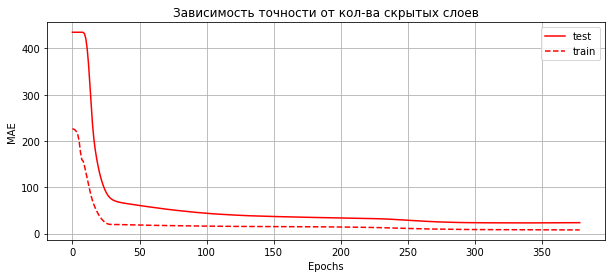

In [29]:
plt.figure(figsize=(10, 4))

plt.plot(history_gru.history['val_mae'], 'r-', label='test')
plt.plot(history_gru.history['mae'], 'r--', label='train')

plt.title(f'Зависимость точности от кол-ва скрытых слоев')
plt.legend()
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.show()

Модель на базе GRU двигается по ходу обучения также плавно как и LSTM, но скорость обучения модели GRU быстрее при том же качестве.

In [34]:
pred_train_gru = model_gru.predict(dataset_train).flatten()
pred_test_gru = model_gru.predict(dataset_test).flatten()

4/4 [==============================] - 0s 8ms/step


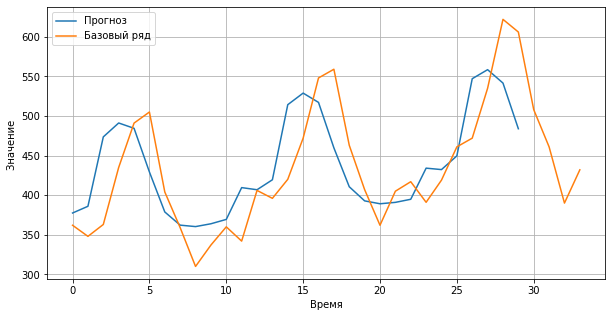

In [35]:
start = 0
step = 50

plt.figure(figsize=(10, 5))
plt.plot(pred_test_gru[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_test.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.grid()
plt.legend()
plt.show()

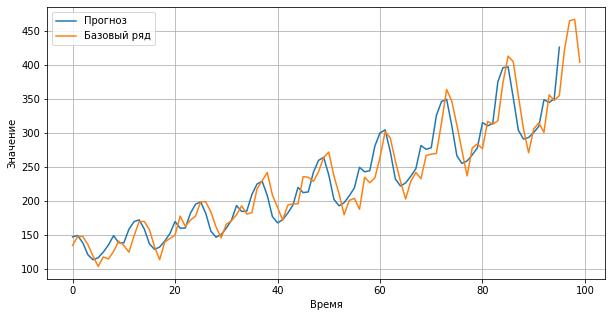

In [36]:
start = 0

plt.figure(figsize=(10, 5))
plt.plot(pred_train_gru[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid()
plt.show()

In [33]:
print(model_gru.evaluate(dataset_train))
print(model_gru.evaluate(dataset_test))

10/10 [==============================] - 0s 4ms/step - loss: 104.1684 - mae: 7.9388
[104.16840362548828, 7.938841342926025]
4/4 [==============================] - 0s 6ms/step - loss: 811.3489 - mae: 23.0479
[811.348876953125, 23.04792594909668]


## Вывод

нарисовать совмещенный график предсказаний с реальными данными

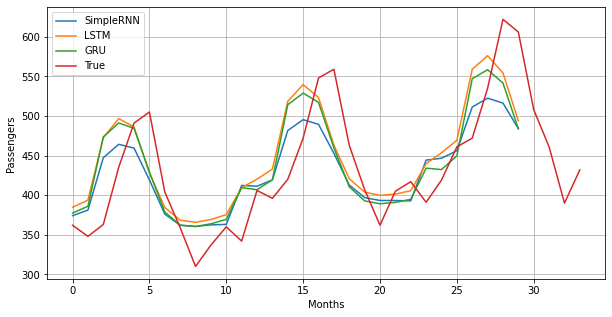

In [45]:
start = 0
step = 50

plt.figure(figsize=(10, 5))

plt.plot(pred_test_rnn[future + start: future + start + step], 
         label='SimpleRNN')
plt.plot(pred_test_lstm[future + start: future + start + step], 
         label='LSTM')
plt.plot(pred_test_gru[future + start: future + start + step], 
         label='GRU')
plt.plot(y_test.flatten()[start: start+step], 
         label='True')
plt.xlabel('Months')
plt.ylabel('Passengers ')

plt.grid()
plt.legend()
plt.show()

Исходя из графика можно сделать вывод, что лучшими моделями оказались LSTM и GRU. А выбор среди этих двух моделей можно определить если знать, что нам важнее - верхние пиковые точки в предсказаниях (LSTM) или более сглаженные предсказания графика(GRU).